In [1]:
import gtdynamics as gtd
import gtsam
import numpy as np
from gtsam import Pose3, Rot3

from cdpr_planar import Cdpr
from cdpr_planar_controller import CdprController
from cdpr_planar_sim import CdprSimulator

In [2]:
# problem parameters
Tf = 1
dt = 0.01
N = int(Tf / dt)
cdpr = Cdpr()
# set up controller
x_des = [
    gtsam.Pose3(gtsam.Rot3(),
                (1.5 + np.cos(2 * np.pi * i / N), 0, 1.5 + np.sin(2 * np.pi * i / N)))
    for i in range(N)
]
# x_des[0] = x_des[1]

In [3]:
# initial state
x0 = gtsam.Values()
gtd.InsertPose(x0, cdpr.ee_id(), 0, x_des[0])
gtd.InsertTwist(x0, cdpr.ee_id(), 0, x_des[0].localCoordinates(x_des[1])*N)

In [4]:
# controller
controller = CdprController(cdpr,
                            x0,
                            x_des,
                            dt=dt,
                            Q=np.array([0, 1, 0, 1e3, 0, 1e3]),
                            R=np.array([1e-3]))

In [5]:
# run simulation
sim = CdprSimulator(cdpr, x0, controller, dt=dt)
result = sim.run(N=N, verbose=False)
poses = [gtd.Pose(result, cdpr.ee_id(), k) for k in range(N+1)]
posesxy = np.array([[pose.x() for pose in poses], [pose.z() for pose in poses]])
desposesxy = np.array([[pose.x() for pose in x_des], [pose.z() for pose in x_des]])
torques = np.array([[gtd.TorqueDouble(result, ji, k) for ji in range(4)] for k in range(N)])

In [6]:
# plot utils
boxinds = np.array([0,1,2,3,0]).reshape(5,1)
def ee_coords(k):
    return (posesxy[:, k]+cdpr.params.b_locs[boxinds, [0,2]]).T
frame_coords = cdpr.params.a_locs[boxinds, [0,2]].T
def cable_coords(k, ji):
    return np.array([[cdpr.params.a_locs[ji][0], posesxy[0][k]+cdpr.params.b_locs[ji][0]],
                     [cdpr.params.a_locs[ji][2], posesxy[1][k]+cdpr.params.b_locs[ji][2]]])

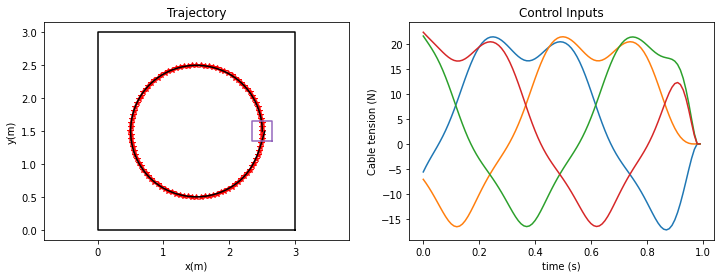

In [7]:
# plot
import matplotlib.pyplot as plt
fig = plt.figure(1, figsize=(12,4))
# xy plot
plt.subplot(1,2,1)
plt.plot(*frame_coords, 'k-')
plt.plot(*desposesxy, 'r*') # desired trajectory
ltraj, = plt.plot(*posesxy, 'k-') # actual trajectory
lscables = plt.plot(np.zeros((2,4)), np.zeros((2,4)))
lee, = plt.plot(*ee_coords(0))
plt.axis('equal')
plt.xlabel('x(m)');plt.ylabel('y(m)');plt.title('Trajectory')
# controls
plt.subplot(1,2,2)
lsctrl = plt.plot(np.arange(0,Tf,dt), torques)
plt.xlabel('time (s)');plt.ylabel('Cable tension (N)');plt.title('Control Inputs');

In [8]:
# animate
plt.rcParams["savefig.dpi"] = 80
import matplotlib.animation as animation
from IPython.display import HTML

def update_line(num):
    ltraj.set_data(posesxy[0][:num], posesxy[1][:num])
    for ji in range(4):
        lsctrl[ji].set_data(np.arange(0,Tf,dt)[:num], torques[:num, ji])
        lscables[ji].set_data(cable_coords(num, ji))
    lee.set_data(*ee_coords(num))
    lines = [ltraj, *lsctrl, *lscables, lee]
    return lines

anim = animation.FuncAnimation(fig, update_line, len(posesxy[0]),
                               interval=100, blit=True)
HTML(anim.to_html5_video())